<a id = "table_of_contents"></a>
# Table of contents

[Import of libraries](#imports)

[Global variables](#global_variables)

[Preprocessing before features generation](#preprocessing_before_fe)

-->[Correct the shop names and id](#correct_shop_names_id)

-->[Generate item_category_features](#generate_item_category_features)

-->[Remove the huge price and item sales outliers](#remove_outliers)

[Generate a full df with all data and records](#generate_full_df_with_all_records)

[Create a groupby df with all the sales for shop_id and item_id grouped by months](#generate_gb_df)

[Join the full_df with gb_df](#join_dfs)

[Add additional features to our full sales df](#add_new_csvs)

[FeatureGenerator class](#fe_generator_class)

[Generate additional features as, mean and total sales for shop_id , item_id, city ... for every month](#create_new_features)

-->[Date and shop_id features](#feature_1)

-->[Date and item_id features](#feature_2)

-->[Date and item_category features](#feature_3)

-->[Datetime features](#feature_5)

-->[Adding holiday and number of weekends data](#feature_6)

-->[City population and mean_income per city](#feature_7)

[Join full sales df with all the features generated](#join_dfs_with_features)

[Basic model train](#basic_model)

[Feature importance](#feature_importance_1)

[Predict and model evaluation](#predict_and_model_evaluation_1)

[To do](#to_do)

-->[Additional feature 1](#new_feature_1)

-->[Additional feature 2](#new_feature_2)

-->[Additional feature 3](#new_feature_3)

-->[Join df's with new features](#join_dfs_with_new_features)

-->[Model training](#new_model)

-->[Feature importance of new model](#feature_importance_2)

-->[Predict and model evaluation of new model](#predict_and_model_evaluation_2)

<a id = "imports"></a>
# Import of libraries
[Go back to the table of contents](#table_of_contents)

In [161]:
# import the basic libraries we will use in this kernel
import os
import numpy as np
import pandas as pd
import pickle

import time
import datetime
from datetime import datetime
import calendar

from sklearn import metrics
from math import sqrt
import gc

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.preprocessing import LabelEncoder

import itertools
import warnings
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

warnings.filterwarnings("ignore") # specify to ignore warning messages

<a id = "global_variables"></a>
# Global variables
[Go back to the table of contents](#table_of_contents)

In [162]:
# Resample the sales by this parameter
PERIOD = "M"

SHOPS = [8, 14, 37, 41, 59]

# this is help us change faster between Kaggle and local machine
LOCAL = False

if LOCAL:
    PATH = os.getcwd()
    FULL_DF_PATH = PATH
    GB_DF_PATH = PATH
    OUTPUT_PATH = PATH
else:
    PATH = '../input/competitive-data-science-predict-future-sales/'
    FULL_DF_PATH = "../input/full-df-only-test-all-features/"
    GB_DF_PATH = "../input/group-by-df/"

<a id = "preprocessing_before_fe"></a>
# Preprocessing before features generation
[Go back to the table of contents](#table_of_contents)

The idea of this section is very simple. We have seen in our EDA part that there are a lot of missing values.
Our model will benefit a lot if we can supply it a training data, with the missing values being zero. This way, it can learn from more amount of data.

In order to do so, we must perform a cartesian operation over dates x shops x items_id to generate all the possible combinations of months x shops and x items sales.

In this kernel we will only generate this type of features for the items that are present in TEST only.

This will reduce the amount of calculations required. If you have enough memory, we can do this for all possible combinations.

In [163]:
# load all the df we have
shops_df = pd.read_csv(os.path.join(PATH, "shops.csv"))
items_df = pd.read_csv(os.path.join(PATH, "items.csv"))
items_category_df = pd.read_csv(os.path.join(PATH, "item_categories.csv"))
sales_df = pd.read_csv(os.path.join(PATH, "sales_train.csv"))
test_df = pd.read_csv(os.path.join(PATH, "test.csv"))

<a id = "correct_shop_names_id"></a>
## Correct the shop names and id
[Go back to the table of contents](#table_of_contents)

In [164]:
# we have seen in our EDA that we have some duplicate shops, let's correct them.
shops_df.loc[shops_df.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops_df['city'] = shops_df['shop_name'].str.split(' ').map(lambda x: x[0])
shops_df.loc[shops_df.city == '!Якутск', 'city'] = 'Якутск'
shops_df['city_code'] = LabelEncoder().fit_transform(shops_df['city'])
shops_df.head()

,shop_name,shop_id,city,city_code
0,"!Якутск Орджоникидзе, 56 фран",0,Якутск,29
1,"!Якутск ТЦ ""Центральный"" фран",1,Якутск,29
2,"Адыгея ТЦ ""Мега""",2,Адыгея,0
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,1
4,"Волжский ТЦ ""Волга Молл""",4,Волжский,2


As we can see, we have some duplicate shop names, let's manually clean them.

In [165]:
shops_df[shops_df["shop_id"].isin([0, 57])]

,shop_name,shop_id,city,city_code
0,"!Якутск Орджоникидзе, 56 фран",0,Якутск,29
57,"Якутск Орджоникидзе, 56",57,Якутск,29


In [166]:
# Якутск Орджоникидзе, 56
sales_df.loc[sales_df.shop_id == 0, 'shop_id'] = 57
test_df.loc[test_df.shop_id == 0, 'shop_id'] = 57

# Якутск ТЦ "Центральный"
sales_df.loc[sales_df.shop_id == 1, 'shop_id'] = 58
test_df.loc[test_df.shop_id == 1, 'shop_id'] = 58

# Жуковский ул. Чкалова 39м²
sales_df.loc[sales_df.shop_id == 10, 'shop_id'] = 11
test_df.loc[test_df.shop_id == 10, 'shop_id'] = 11

<a id = "generate_item_category_features"></a>
## Generate item_category_features
[Go back to the table of contents](#table_of_contents)

In [167]:
items_category_df['split'] = items_category_df['item_category_name'].str.split('-')
items_category_df['type'] = items_category_df['split'].map(lambda x: x[0].strip())
items_category_df['type_code'] = LabelEncoder().fit_transform(items_category_df['type'])

# if subtype is nan then type
items_category_df['subtype'] = items_category_df['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
items_category_df['subtype_code'] = LabelEncoder().fit_transform(items_category_df['subtype'])

items_category_df.head()

,item_category_name,item_category_id,split,type,type_code,subtype,subtype_code
0,PC - Гарнитуры/Наушники,0,"[PC , Гарнитуры/Наушники]",PC,0,Гарнитуры/Наушники,29
1,Аксессуары - PS2,1,"[Аксессуары , PS2]",Аксессуары,1,PS2,9
2,Аксессуары - PS3,2,"[Аксессуары , PS3]",Аксессуары,1,PS3,10
3,Аксессуары - PS4,3,"[Аксессуары , PS4]",Аксессуары,1,PS4,11
4,Аксессуары - PSP,4,"[Аксессуары , PSP]",Аксессуары,1,PSP,13


<a id = "remove_outliers"></a>
## Remove the huge price and item sales outliers
[Go back to the table of contents](#table_of_contents)

In [168]:
sales_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [169]:
# we have negative prices and some outlier
# let's replace the data with the mean value and also filter all the outliers
mean = sales_df[(sales_df["shop_id"] == 32) & (sales_df["item_id"] == 2973) & (sales_df["date_block_num"] == 4) & (sales_df["item_price"] > 0)]["item_price"].mean()
sales_df.loc[sales_df.item_price < 0, 'item_price'] = mean

sales_df = sales_df[sales_df["item_price"] < np.percentile(sales_df["item_price"], q = 100)]
sales_df = sales_df[sales_df["item_cnt_day"] < np.percentile(sales_df["item_cnt_day"], q = 100)]

<a id = "generate_full_df_with_all_records"></a>
# Generate a full df with all data and records
[Go back to the table of contents](#table_of_contents)

In [170]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935847 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 156.8+ MB


In [171]:
type(sales_df["date"].iloc[0])

str

In [172]:
# convert to datetime the date column
# specify the format since otherwise it might give some problems
sales_df["date"] = pd.to_datetime(sales_df["date"], format = "%d.%m.%Y")

In [173]:
# max date in sales is 31.10.2015.
# In the Kaggle competition we are asked to predict the sales for the next month
# this means the sales of November
min_date = sales_df["date"].min()
max_date_sales = sales_df["date"].max()

In [174]:
max_date_sales

Timestamp('2015-10-31 00:00:00')

In [175]:
# how to createa a new date
max_date_test = datetime(2015, 11, 30)

In [176]:
# create a date range that beggins with the first sale and ends with the last day from our max_date_test
# Notice however, that we will train our model only a selection of shops and will test our data on october data.
date_range = pd.date_range(min_date, max_date_sales, freq = "D")
date_range

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2015-10-22', '2015-10-23', '2015-10-24', '2015-10-25',
               '2015-10-26', '2015-10-27', '2015-10-28', '2015-10-29',
               '2015-10-30', '2015-10-31'],
              dtype='datetime64[ns]', length=1034, freq='D')

In [177]:
len(date_range)

1034

Our model will benefit a lot if we can train it with the highest granularity (daily sales).

However, as we can see doing this on a local machine is almost impossible since we have more than 1.4 BILLION rows.
If we add 10 featrues (columns) this means that our total DataFrame will have more than 10.4 BILLIONS instances.

In [178]:
shops = sorted(list(shops_df["shop_id"].unique()))

# only items present in test
items = sorted(list(items_df["item_id"].unique()))

cartesian_product = pd.MultiIndex.from_product([date_range, shops, items], names = ["date", "shop_id", "item_id"])
len(cartesian_product)

1375426800

In order to replicate the Kaggle competition, we will create a smaller DataFrame with only selected shops and train the model on a Monthly basis.


We will use only 5 shops since generating a lot of features will consume a lot of memory and we won't be able to train on Kaggle. If you have a more powerful machine, you can run the script with all shops.

In [179]:
date_range = pd.date_range(min_date, max_date_sales, freq = PERIOD)
print("We have a total of {} months".format(len(date_range)))
date_range

We have a total of 34 months


DatetimeIndex(['2013-01-31', '2013-02-28', '2013-03-31', '2013-04-30',
               '2013-05-31', '2013-06-30', '2013-07-31', '2013-08-31',
               '2013-09-30', '2013-10-31', '2013-11-30', '2013-12-31',
               '2014-01-31', '2014-02-28', '2014-03-31', '2014-04-30',
               '2014-05-31', '2014-06-30', '2014-07-31', '2014-08-31',
               '2014-09-30', '2014-10-31', '2014-11-30', '2014-12-31',
               '2015-01-31', '2015-02-28', '2015-03-31', '2015-04-30',
               '2015-05-31', '2015-06-30', '2015-07-31', '2015-08-31',
               '2015-09-30', '2015-10-31'],
              dtype='datetime64[ns]', freq='M')

0.87 million rows, we CAN work with this on a local machine.

We have created monthly date_range, if we want to join this with our sales data, we must "resample" our data to a monthly date_range aswell.

In [180]:
# only items present in test
items = sorted(list(test_df["item_id"].unique()))

cartesian_product = pd.MultiIndex.from_product([date_range, SHOPS, items], names = ["date", "shop_id", "item_id"])
len(cartesian_product)

867000

<a id = "generate_gb_df"></a>
# Create a groupby df with all the sales for shop_id and item_id grouped by months
[Go back to the table of contents](#table_of_contents)

We will be working with a DataFrame resampled by Months. We must resample the sales_df.

In [181]:
'''
st = time.time()

# # set index
sales_df["revenue"] = sales_df["item_cnt_day"]*sales_df["item_price"]
gb_df = sales_df.set_index("date")

# # groupby shop_id and item_id
gb_df = gb_df.groupby(["shop_id", "item_id"])

# # resample the sales to a weekly basis
gb_df = gb_df.resample(PERIOD).agg({'item_cnt_day': np.sum, "item_price": np.mean, "revenue":np.sum})

# # convert to dataframe and save the full dataframe
gb_df.reset_index(inplace = True)

# # save the groupby dataframe
gb_df.to_pickle("GROUP_BY_DF.pkl")

et = time.time()

print("Total time in minutes to preprocess took {}".format((et - st)/60))
'''


'\nst = time.time()\n\n# # set index\nsales_df["revenue"] = sales_df["item_cnt_day"]*sales_df["item_price"]\ngb_df = sales_df.set_index("date")\n\n# # groupby shop_id and item_id\ngb_df = gb_df.groupby(["shop_id", "item_id"])\n\n# # resample the sales to a weekly basis\ngb_df = gb_df.resample(PERIOD).agg({\'item_cnt_day\': np.sum, "item_price": np.mean, "revenue":np.sum})\n\n# # convert to dataframe and save the full dataframe\ngb_df.reset_index(inplace = True)\n\n# # save the groupby dataframe\ngb_df.to_pickle("GROUP_BY_DF.pkl")\n\net = time.time()\n\nprint("Total time in minutes to preprocess took {}".format((et - st)/60))\n'

In [182]:
# read the groupby dataframe
gb_df = pd.read_pickle(os.path.join(GB_DF_PATH, "GROUP_BY_DF.pkl"))
# gb_df = pd.read_pickle("GROUP_BY_DF.pkl")

In [183]:
gb_df.head()

,shop_id,item_id,date,item_cnt_day,item_price,revenue
0,2,27,2013-01-31,1.0,2499.0,2499.0
1,2,27,2013-02-28,NaN,NaN,NaN
2,2,27,2013-03-31,NaN,NaN,NaN
3,2,27,2013-04-30,NaN,NaN,NaN
4,2,27,2013-05-31,NaN,NaN,NaN


In [184]:
gb_df.fillna(0, inplace = True)

<a id = "join_dfs"></a>
# Join the full_df with gb_df
[Go back to the table of contents](#table_of_contents)

Now that we have the sales_df resampled by months, and we have created a cartesian product (all possible combinations of months, shop_id and item_id), let's merge the df.

In [185]:
full_df = pd.DataFrame(index = cartesian_product).reset_index()

full_df = pd.merge(full_df, gb_df, on = ['date','shop_id', "item_id"], how = 'left')

In [186]:
full_df.shape

(867000, 6)

In [187]:
full_df.head()

,date,shop_id,item_id,item_cnt_day,item_price,revenue
0,2013-01-31,8,30,NaN,NaN,NaN
1,2013-01-31,8,31,NaN,NaN,NaN
2,2013-01-31,8,32,NaN,NaN,NaN
3,2013-01-31,8,33,1.0,499.0,499.0
4,2013-01-31,8,38,NaN,NaN,NaN


<a id = "add_new_csvs"></a>
# Add additional features to our full sales df
[Go back to the table of contents](#table_of_contents)

In [188]:
# add shops_df information
full_df = pd.merge(full_df, shops_df, on = "shop_id")
full_df.head()

,date,shop_id,item_id,item_cnt_day,item_price,revenue,shop_name,city,city_code
0,2013-01-31,8,30,NaN,NaN,NaN,"Воронеж ТРЦ Сити-Парк ""Град""",Воронеж,4
1,2013-01-31,8,31,NaN,NaN,NaN,"Воронеж ТРЦ Сити-Парк ""Град""",Воронеж,4
2,2013-01-31,8,32,NaN,NaN,NaN,"Воронеж ТРЦ Сити-Парк ""Град""",Воронеж,4
3,2013-01-31,8,33,1.0,499.0,499.0,"Воронеж ТРЦ Сити-Парк ""Град""",Воронеж,4
4,2013-01-31,8,38,NaN,NaN,NaN,"Воронеж ТРЦ Сити-Парк ""Град""",Воронеж,4


In [189]:
# add items_df information
full_df = pd.merge(full_df, items_df, on = "item_id")
full_df.head()

,date,shop_id,item_id,item_cnt_day,item_price,revenue,shop_name,city,city_code,item_name,item_category_id
0,2013-01-31,8,30,NaN,NaN,NaN,"Воронеж ТРЦ Сити-Парк ""Град""",Воронеж,4,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40
1,2013-02-28,8,30,6.0,399.0,2394.0,"Воронеж ТРЦ Сити-Парк ""Град""",Воронеж,4,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40
2,2013-03-31,8,30,1.0,399.0,399.0,"Воронеж ТРЦ Сити-Парк ""Град""",Воронеж,4,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40
3,2013-04-30,8,30,NaN,NaN,NaN,"Воронеж ТРЦ Сити-Парк ""Град""",Воронеж,4,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40
4,2013-05-31,8,30,NaN,NaN,NaN,"Воронеж ТРЦ Сити-Парк ""Град""",Воронеж,4,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40


In [190]:
# add items_category_df information
full_df = pd.merge(full_df, items_category_df, on = "item_category_id")
full_df.head()

,date,shop_id,item_id,item_cnt_day,item_price,revenue,shop_name,city,city_code,item_name,item_category_id,item_category_name,split,type,type_code,subtype,subtype_code
0,2013-01-31,8,30,NaN,NaN,NaN,"Воронеж ТРЦ Сити-Парк ""Град""",Воронеж,4,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40,Кино - DVD,"[Кино , DVD]",Кино,11,DVD,4
1,2013-02-28,8,30,6.0,399.0,2394.0,"Воронеж ТРЦ Сити-Парк ""Град""",Воронеж,4,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40,Кино - DVD,"[Кино , DVD]",Кино,11,DVD,4
2,2013-03-31,8,30,1.0,399.0,399.0,"Воронеж ТРЦ Сити-Парк ""Град""",Воронеж,4,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40,Кино - DVD,"[Кино , DVD]",Кино,11,DVD,4
3,2013-04-30,8,30,NaN,NaN,NaN,"Воронеж ТРЦ Сити-Парк ""Град""",Воронеж,4,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40,Кино - DVD,"[Кино , DVD]",Кино,11,DVD,4
4,2013-05-31,8,30,NaN,NaN,NaN,"Воронеж ТРЦ Сити-Парк ""Град""",Воронеж,4,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40,Кино - DVD,"[Кино , DVD]",Кино,11,DVD,4


In [191]:
full_df.fillna(0, inplace = True)

In [192]:
# We will clip the value in this line.
# This means that the values greater than 20, will become 20 and lesser than 20
full_df["item_cnt_day"] = np.clip(full_df["item_cnt_day"], 0, 20)

<a id = "fe_generator_class"></a>
# FeatureGenerator class
[Go back to the table of contents](#table_of_contents)

In [193]:
class FeatureGenerator(object):
    
    '''
    This is a helper class that takes a df and a list of features and creates sum, mean, 
    lag features and variation (change over month) features.
    
    '''
    
    def __init__(self, full_df,  gb_list):
        
        '''
        Constructor of the class.
        gb_list is a list of columns that must be in full_df.
        '''
        
        self.full_df = full_df
        self.gb_list = gb_list
        # joins the gb_list, this way we can dinamically create new columns
        # ["date, "shop_id] --> date_shop_id
        self.objective_column_name = "_".join(gb_list)
            
    def generate_gb_df(self):
        
        '''
        This function thakes the full_df and creates a groupby df based on the gb_list.
        It creates 2 columns: 
            1. A sum column for every date and gb_list
            2. Mean columns for every_date and gb_list
            
        The resulting df (gb_df_) is assigned back to the FeatureGenerator class as an attribute.
        '''

        def my_agg(full_df_, args):
            
            '''
            This function is used to perform multiple operations over a groupby df and returns a df
            without multiindex.
            '''
            
            names = {
                # you can put here as many columns as you want 
                '{}_sum'.format(args):  full_df_['item_cnt_day'].sum()
            }

            return pd.Series(names, index = [key for key in names.keys()])
        
        # the args is used to pass additional argument to the apply function
        gb_df_ = self.full_df.groupby(self.gb_list).apply(my_agg, args = (self.objective_column_name)).reset_index()

        self.gb_df_ = gb_df_

        
    def return_gb_df(self):  
        
        '''
        This function takes the gb_df_ created in the previous step (generate_gb_df) and creates additional features.
        We create 3 lag features (values from the past).
        And 6 variation features: 3 with absolute values and 3 with porcentual change.
        '''
        
        def generate_shift_features(self, suffix):
            
            '''
            This function is a helper function that takes the gb_df_ and a suffix (sum or mean) and creates the
            additional features.
            '''

            # dinamically creates the features
            # date_shop_id --> date_shop_id_sum if suffix is sum
            # date_shop_id --> date_shop_id_mean if suffix is mean
            name_ = self.objective_column_name + "_" + suffix

            self.gb_df_['{}_shift_1'.format(name_)] =\
            self.gb_df_.groupby(self.gb_list[1:])[name_].transform(lambda x: x.shift(1))
            
            self.gb_df_['{}_shift_2'.format(name_)] =\
            self.gb_df_.groupby(self.gb_list[1:])[name_].transform(lambda x: x.shift(2))
            
            self.gb_df_['{}_shift_3'.format(name_)] =\
            self.gb_df_.groupby(self.gb_list[1:])[name_].transform(lambda x: x.shift(3))

            self.gb_df_['{}_var_pct_1'.format(name_)] =\
            self.gb_df_.groupby(self.gb_list[1:])[name_].transform(lambda x: (x.shift(1) - x.shift(2))/x.shift(2))
            
            self.gb_df_['{}_var_pct_2'.format(name_)] =\
            self.gb_df_.groupby(self.gb_list[1:])[name_].transform(lambda x: (x.shift(1) - x.shift(3))/x.shift(3))
            
            self.gb_df_['{}_var_pct_3'.format(name_)] =\
            self.gb_df_.groupby(self.gb_list[1:])[name_].transform(lambda x: (x.shift(1) - x.shift(4))/x.shift(4))
            
            self.gb_df_.fillna(-1, inplace = True)

            self.gb_df_.replace([np.inf, -np.inf], -1, inplace = True)
        
        # call the generate_shift_featues function with different suffix (sum and mean)
        generate_shift_features(self, suffix = "sum")
    
        return self.gb_df_
        

<a id = "create_new_features"></a>
# Generate additional features as, mean and total sales for shop_id , item_id, city ... for every month
[Go back to the table of contents](#table_of_contents)

<a id = "feature_1"></a>
## Date and shop_id features
[Go back to the table of contents](#table_of_contents)

In [194]:
st = time.time()

gb_list = ["date", "shop_id", "city"]

fe_generator = FeatureGenerator(full_df = full_df, gb_list = gb_list)

fe_generator.generate_gb_df()

shop_sales_features = fe_generator.return_gb_df()

# to avoid city_x and city_y

shop_sales_features.drop("city", axis = 1, inplace = True)
et = time.time()

(et - st)/60

0.024079561233520508

In [195]:
shop_sales_features.shape

(170, 9)

In [196]:
shop_sales_features[shop_sales_features["shop_id"] == 8].head(5)

,date,shop_id,date_shop_id_city_sum,date_shop_id_city_sum_shift_1,date_shop_id_city_sum_shift_2,date_shop_id_city_sum_shift_3,date_shop_id_city_sum_var_pct_1,date_shop_id_city_sum_var_pct_2,date_shop_id_city_sum_var_pct_3
0,2013-01-31,8,322.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.0
5,2013-02-28,8,270.0,322.0,-1.0,-1.0,-1.000000,-1.000000,-1.0
10,2013-03-31,8,285.0,270.0,322.0,-1.0,-0.161491,-1.000000,-1.0
15,2013-04-30,8,0.0,285.0,270.0,322.0,0.055556,-0.114907,-1.0
20,2013-05-31,8,0.0,0.0,285.0,270.0,-1.000000,-1.000000,-1.0


<a id = "feature_2"></a>
## Date and item_id features
[Go back to the table of contents](#table_of_contents)

In [197]:
st = time.time()

gb_list = ["date", "item_id"]

fe_generator = FeatureGenerator(full_df = full_df, gb_list = gb_list)

fe_generator.generate_gb_df()

item_sales_features = fe_generator.return_gb_df()

et = time.time()

(et - st)/60

3.631659507751465

In [198]:
item_sales_features.shape

(173400, 9)

In [199]:
item_sales_features[item_sales_features["item_id"] == 30].head(3)

,date,item_id,date_item_id_sum,date_item_id_sum_shift_1,date_item_id_sum_shift_2,date_item_id_sum_shift_3,date_item_id_sum_var_pct_1,date_item_id_sum_var_pct_2,date_item_id_sum_var_pct_3
0,2013-01-31,30,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
5100,2013-02-28,30,44.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0
10200,2013-03-31,30,26.0,44.0,0.0,-1.0,-1.0,-1.0,-1.0


<a id = "feature_3"></a>
## Date and item_category features
[Go back to the table of contents](#table_of_contents)

In [200]:
st = time.time()

gb_list = ["date", "item_category_id"]

fe_generator = FeatureGenerator(full_df = full_df, gb_list = gb_list)

fe_generator.generate_gb_df()

month_item_category_features = fe_generator.return_gb_df()

et = time.time()

(et - st)/60

0.053467706839243574

In [201]:
month_item_category_features.shape

(2108, 9)

In [202]:
month_item_category_features[month_item_category_features["item_category_id"] == 2].head(3)

,date,item_category_id,date_item_category_id_sum,date_item_category_id_sum_shift_1,date_item_category_id_sum_shift_2,date_item_category_id_sum_shift_3,date_item_category_id_sum_var_pct_1,date_item_category_id_sum_var_pct_2,date_item_category_id_sum_var_pct_3
1,2013-01-31,2,44.0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0
63,2013-02-28,2,28.0,44.0,-1.0,-1.0,-1.000000,-1.0,-1.0
125,2013-03-31,2,11.0,28.0,44.0,-1.0,-0.363636,-1.0,-1.0


<a id = "feature_5"></a>
## Datetime features
[Go back to the table of contents](#table_of_contents)

In [203]:
full_df["year"] = full_df["date"].dt.year
full_df["month"] = full_df["date"].dt.month
full_df["days_in_month"] = full_df["date"].dt.days_in_month

<a id = "feature_6"></a>
## Adding holiday and number of weekends data
[Go back to the table of contents](#table_of_contents)

In [204]:
holidays_next_month = {
    12:8,
    1:1,
    2:1,
    3:0,
    4:2,
    5:1,
    6:0,
    7:0,
    8:0,
    9:0,
    10:1,
    11:0
}

holidays_this_month = {
    1:8,
    2:1,
    3:1,
    4:0,
    5:2,
    6:1,
    7:0,
    8:0,
    9:0,
    10:0,
    11:1,
    12:0
}

full_df["holidays_next_month"] = full_df["month"].map(holidays_next_month)
full_df["holidays_this_month"] = full_df["month"].map(holidays_this_month)

In [205]:
def extract_number_weekends(test_month):
    '''
    Extracts the number of weekend days in a month.
    '''
    saturdays = len([1 for i in calendar.monthcalendar(test_month.year, test_month.month) if i[5] != 0])
    sundays = len([1 for i in calendar.monthcalendar(test_month.year, test_month.month) if i[6] != 0])
    
    return saturdays + sundays

full_df["total_weekend_days"] = full_df["date"].apply(extract_number_weekends)

# how much time has passed since the last sale?
date_diff_df = full_df[full_df["item_cnt_day"] > 0][["shop_id", "item_id", "date", "item_cnt_day"]].groupby(["shop_id", "item_id"])\
["date"].diff().apply(lambda timedelta_: timedelta_.days).to_frame()
date_diff_df.columns = ["date_diff_sales"]

full_df = pd.merge(full_df, date_diff_df, how = "left", left_index=True, right_index=True)
full_df.fillna(-1, inplace = True)

In [206]:
full_df.head()

,date,shop_id,item_id,item_cnt_day,item_price,revenue,shop_name,city,city_code,item_name,...,type_code,subtype,subtype_code,year,month,days_in_month,holidays_next_month,holidays_this_month,total_weekend_days,date_diff_sales
0,2013-01-31,8,30,0.0,0.0,0.0,"Воронеж ТРЦ Сити-Парк ""Град""",Воронеж,4,007: КООРДИНАТЫ «СКАЙФОЛЛ»,...,11,DVD,4,2013,1,31,1,8,8,-1.0
1,2013-02-28,8,30,6.0,399.0,2394.0,"Воронеж ТРЦ Сити-Парк ""Град""",Воронеж,4,007: КООРДИНАТЫ «СКАЙФОЛЛ»,...,11,DVD,4,2013,2,28,1,1,8,-1.0
2,2013-03-31,8,30,1.0,399.0,399.0,"Воронеж ТРЦ Сити-Парк ""Град""",Воронеж,4,007: КООРДИНАТЫ «СКАЙФОЛЛ»,...,11,DVD,4,2013,3,31,0,1,10,31.0
3,2013-04-30,8,30,0.0,0.0,0.0,"Воронеж ТРЦ Сити-Парк ""Град""",Воронеж,4,007: КООРДИНАТЫ «СКАЙФОЛЛ»,...,11,DVD,4,2013,4,30,2,0,8,-1.0
4,2013-05-31,8,30,0.0,0.0,0.0,"Воронеж ТРЦ Сити-Парк ""Град""",Воронеж,4,007: КООРДИНАТЫ «СКАЙФОЛЛ»,...,11,DVD,4,2013,5,31,1,2,8,-1.0


<a id = "feature_7"></a>
## City population and mean_income per city
[Go back to the table of contents](#table_of_contents)

In [207]:
city_population = {\
'Якутск':307911, 
'Адыгея':141970,
'Балашиха':450771, 
'Волжский':326055, 
'Вологда':313012, 
'Воронеж':1047549,
'Выездная':1228680, 
'Жуковский':107560, 
'Интернет-магазин':1228680, 
'Казань':1257391, 
'Калуга':341892,
'Коломна':140129,
'Красноярск':1083865, 
'Курск':452976, 
'Москва':12678079,
'Мытищи':205397, 
'Н.Новгород':1252236,
'Новосибирск':1602915 , 
'Омск':1178391, 
'РостовНаДону':1125299, 
'СПб':5398064, 
'Самара':1156659,
'СергиевПосад':104579, 
'Сургут':373940, 
'Томск':572740, 
'Тюмень':744554, 
'Уфа':1115560, 
'Химки':244668,
'Цифровой':1228680, 
'Чехов':70548, 
'Ярославль':608353
}

city_income = {\
'Якутск':70969, 
'Адыгея':28842,
'Балашиха':54122, 
'Волжский':31666, 
'Вологда':38201, 
'Воронеж':32504,
'Выездная':46158, 
'Жуковский':54122, 
'Интернет-магазин':46158, 
'Казань':36139, 
'Калуга':39776,
'Коломна':54122,
'Красноярск':48831, 
'Курск':31391, 
'Москва':91368,
'Мытищи':54122, 
'Н.Новгород':31210,
'Новосибирск':37014 , 
'Омск':34294, 
'РостовНаДону':32067, 
'СПб':61536, 
'Самара':35218,
'СергиевПосад':54122, 
'Сургут':73780, 
'Томск':43235, 
'Тюмень':72227, 
'Уфа':35257, 
'Химки':54122,
'Цифровой':46158, 
'Чехов':54122, 
'Ярославль':34675
}

full_df["city_population"] = full_df["city"].map(city_population)
full_df["city_income"] = full_df["city"].map(city_income)
full_df["price_over_income"] = full_df["item_price"]/full_df["city_income"]

<a id = "join_dfs_with_features"></a>
# Join full sales df with all the features generated
[Go back to the table of contents](#table_of_contents)

In [208]:
print("Shape before merge is {}".format(full_df.shape))

full_df = pd.merge(full_df, shop_sales_features, on = ["date", "shop_id"], how = "left")
full_df = pd.merge(full_df, item_sales_features, on = ["date", "item_id"], how = "left")
full_df = pd.merge(full_df, month_item_category_features, on = ["date", "item_category_id"], how = "left")
full_df.rename(columns = {"item_cnt_day":"sales"}, inplace = True)

print("Shape after merge is {}".format(full_df.shape))

Shape before merge is (867000, 27)
Shape after merge is (867000, 48)


In [209]:
# save the file

st = time.time()

full_df.to_pickle("FULL_DF_ONLY_TEST_ALL_FEATURES.pkl")

et = time.time()
(et - st)/60

0.02651898463567098

<a id = "basic_model"></a>
# Basic model train
[Go back to the table of contents](#table_of_contents)

In [210]:
# load the preprocessed data
full_df = pd.read_pickle("FULL_DF_ONLY_TEST_ALL_FEATURES.pkl")

# select only a few shops
full_df = full_df[full_df["shop_id"].isin(SHOPS)]

# delete all the columns where lags features are - 1 (shift(6))
full_df = full_df[full_df["date"] > np.datetime64("2013-03-31")]

cols_to_drop = [

'revenue',
'shop_name',
"city",
'item_name',
'item_category_name',
'split',
'type',
'subtype',

'date_item_id_sum',
"date_shop_id_city_sum",
"date_item_category_id_sum",
    
]

# We create a new DF without the dropped columns to use it afterwards:

full_df_2=full_df.copy(deep=True)


# Then we drop the columns for the first option:

full_df.drop(cols_to_drop, inplace = True, axis = 1)

In [211]:
# ------------------------------------------------------
# separate the dates for train, validation and test

train_index = sorted(list(full_df["date"].unique()))[:-2]

valida_index = [sorted(list(full_df["date"].unique()))[-2]]

test_index = [sorted(list(full_df["date"].unique()))[-1]]

# ------------------------------------------------------
# split the data into train, validation and test dataset
# we "simulate" the test dataset to be the Kaggle test dataset

X_train = full_df[full_df["date"].isin(train_index)].drop(['sales', "date"], axis=1)
Y_train = full_df[full_df["date"].isin(train_index)]['sales']

X_valida = full_df[full_df["date"].isin(valida_index)].drop(['sales', "date"], axis=1)
Y_valida = full_df[full_df["date"].isin(valida_index)]['sales']

X_test = full_df[full_df["date"].isin(test_index)].drop(['sales', "date"], axis = 1)
Y_test = full_df[full_df["date"].isin(test_index)]['sales']

In [212]:
st = time.time()

model = XGBRegressor(seed = 175)

model_name = str(model).split("(")[0]

day = str(datetime.now()).split()[0].replace("-", "_")
hour = str(datetime.now()).split()[1].replace(":", "_").split(".")[0]
t = str(day) + "_" + str(hour)

model.fit(X_train, Y_train, eval_metric = "rmse", 
    eval_set = [(X_train, Y_train), (X_valida, Y_valida)], 
    verbose = True, 
    early_stopping_rounds = 10)

et = time.time()

print("Training took {} minutes!".format((et - st)/60))

[0]	validation_0-rmse:0.67092	validation_1-rmse:0.68370
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:0.56469	validation_1-rmse:0.58253
[2]	validation_0-rmse:0.50324	validation_1-rmse:0.52616
[3]	validation_0-rmse:0.46880	validation_1-rmse:0.50321
[4]	validation_0-rmse:0.44840	validation_1-rmse:0.49062
[5]	validation_0-rmse:0.43476	validation_1-rmse:0.48777
[6]	validation_0-rmse:0.42564	validation_1-rmse:0.48514
[7]	validation_0-rmse:0.41927	validation_1-rmse:0.48299
[8]	validation_0-rmse:0.41558	validation_1-rmse:0.48401
[9]	validation_0-rmse:0.40610	validation_1-rmse:0.47895
[10]	validation_0-rmse:0.39823	validation_1-rmse:0.48354
[11]	validation_0-rmse:0.38998	validation_1-rmse:0.48280
[12]	validation_0-rmse:0.38483	validation_1-rmse:0.47912
[13]	validation_0-rmse:0.38318	validation_1-rmse:0.48045
[14]	validation_0-rmse:0.38224	validation_1-rmse:0.48

In [213]:
pickle.dump(model, open("{}_{}.dat".format(model_name, t), "wb"))

In [214]:
print("{}_{}.dat".format(model_name, t))

XGBRegressor_2020_12_04_12_04_17.dat


In [215]:
model = pickle.load(open("{}_{}.dat".format(model_name, t), "rb"))

<a id = "feature_importance_1"></a>
# Feature importance
[Go back to the table of contents](#table_of_contents)

In [216]:
importance = model.get_booster().get_score(importance_type = "gain")

importance = {k: v for k, v in sorted(importance.items(), key = lambda item: item[1])}

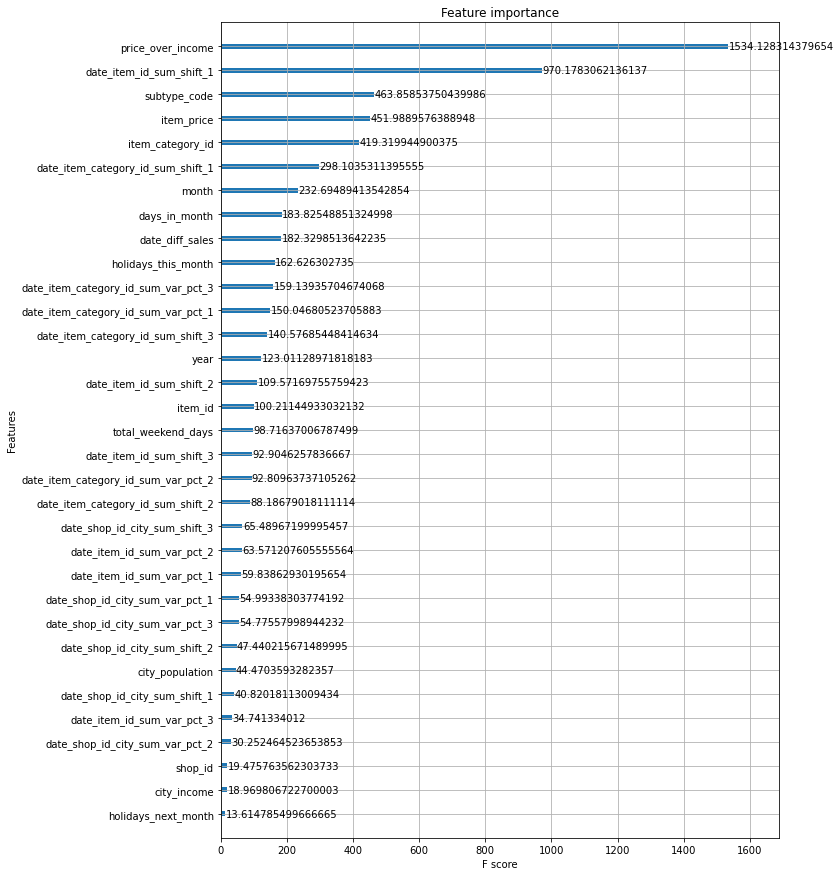

In [217]:
fig, ax = plt.subplots(figsize = (10, 15))
plot_importance(model, importance_type = "gain", ax = ax);

<a id = "predict_and_model_evaluation_1"></a>
# Predict and model evaluation
[Go back to the table of contents](#table_of_contents)

In [218]:
Y_valida_pred = model.predict(X_valida)

rmse_valida = sqrt(metrics.mean_squared_error(Y_valida, Y_valida_pred))
rmse_valida

0.4694117299583653

In [219]:
Y_test_predict = model.predict(X_test)

rmse_test = sqrt(metrics.mean_squared_error(Y_test, Y_test_predict))
rmse_test

0.446482851814812

<a id = "to_do"></a>
# To do
[Go back to the table of contents](#table_of_contents)

In [220]:
full_df_2.head(30).T

,3,4,5,6,7,8,9,10,11,12,...,23,24,25,26,27,28,29,30,31,32
date,2013-04-30 00:00:00,2013-05-31 00:00:00,2013-06-30 00:00:00,2013-07-31 00:00:00,2013-08-31 00:00:00,2013-09-30 00:00:00,2013-10-31 00:00:00,2013-11-30 00:00:00,2013-12-31 00:00:00,2014-01-31 00:00:00,...,2014-12-31 00:00:00,2015-01-31 00:00:00,2015-02-28 00:00:00,2015-03-31 00:00:00,2015-04-30 00:00:00,2015-05-31 00:00:00,2015-06-30 00:00:00,2015-07-31 00:00:00,2015-08-31 00:00:00,2015-09-30 00:00:00
shop_id,8,8,8,8,8,8,8,8,8,8,...,8,8,8,8,8,8,8,8,8,8
item_id,30,30,30,30,30,30,30,30,30,30,...,30,30,30,30,30,30,30,30,30,30
sales,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
item_price,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
revenue,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
shop_name,"Воронеж ТРЦ Сити-Парк ""Град""","Воронеж ТРЦ Сити-Парк ""Град""","Воронеж ТРЦ Сити-Парк ""Град""","Воронеж ТРЦ Сити-Парк ""Град""","Воронеж ТРЦ Сити-Парк ""Град""","Воронеж ТРЦ Сити-Парк ""Град""","Воронеж ТРЦ Сити-Парк ""Град""","Воронеж ТРЦ Сити-Парк ""Град""","Воронеж ТРЦ Сити-Парк ""Град""","Воронеж ТРЦ Сити-Парк ""Град""",...,"Воронеж ТРЦ Сити-Парк ""Град""","Воронеж ТРЦ Сити-Парк ""Град""","Воронеж ТРЦ Сити-Парк ""Град""","Воронеж ТРЦ Сити-Парк ""Град""","Воронеж ТРЦ Сити-Парк ""Град""","Воронеж ТРЦ Сити-Парк ""Град""","Воронеж ТРЦ Сити-Парк ""Град""","Воронеж ТРЦ Сити-Парк ""Град""","Воронеж ТРЦ Сити-Парк ""Град""","Воронеж ТРЦ Сити-Парк ""Град"""
city,Воронеж,Воронеж,Воронеж,Воронеж,Воронеж,Воронеж,Воронеж,Воронеж,Воронеж,Воронеж,...,Воронеж,Воронеж,Воронеж,Воронеж,Воронеж,Воронеж,Воронеж,Воронеж,Воронеж,Воронеж
city_code,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
item_name,007: КООРДИНАТЫ «СКАЙФОЛЛ»,007: КООРДИНАТЫ «СКАЙФОЛЛ»,007: КООРДИНАТЫ «СКАЙФОЛЛ»,007: КООРДИНАТЫ «СКАЙФОЛЛ»,007: КООРДИНАТЫ «СКАЙФОЛЛ»,007: КООРДИНАТЫ «СКАЙФОЛЛ»,007: КООРДИНАТЫ «СКАЙФОЛЛ»,007: КООРДИНАТЫ «СКАЙФОЛЛ»,007: КООРДИНАТЫ «СКАЙФОЛЛ»,007: КООРДИНАТЫ «СКАЙФОЛЛ»,...,007: КООРДИНАТЫ «СКАЙФОЛЛ»,007: КООРДИНАТЫ «СКАЙФОЛЛ»,007: КООРДИНАТЫ «СКАЙФОЛЛ»,007: КООРДИНАТЫ «СКАЙФОЛЛ»,007: КООРДИНАТЫ «СКАЙФОЛЛ»,007: КООРДИНАТЫ «СКАЙФОЛЛ»,007: КООРДИНАТЫ «СКАЙФОЛЛ»,007: КООРДИНАТЫ «СКАЙФОЛЛ»,007: КООРДИНАТЫ «СКАЙФОЛЛ»,007: КООРДИНАТЫ «СКАЙФОЛЛ»


In [221]:
# Clase para generar variables adicionales:

class FeatureGenerator(object):
    
    '''
    This is a helper class that takes a df and a list of features and creates sum, mean, 
    lag features and variation (change over month) features.
    
    '''
    
    def __init__(self, full_df,  gb_list):
        
        '''
        Constructor of the class.
        gb_list is a list of columns that must be in full_df.
        '''
        
        self.full_df = full_df
        self.gb_list = gb_list
        # joins the gb_list, this way we can dinamically create new columns
        # ["date, "shop_id] --> date_shop_id
        self.objective_column_name = "_".join(gb_list)
            
    def generate_gb_df(self):
        
        '''
        This function thakes the full_df and creates a groupby df based on the gb_list.
        It creates 2 columns: 
            1. A sum column for every date and gb_list
            2. Mean columns for every_date and gb_list
            
        The resulting df (gb_df_) is assigned back to the FeatureGenerator class as an attribute.
        '''

        def my_agg(full_df_, args):
            
            '''
            This function is used to perform multiple operations over a groupby df and returns a df
            without multiindex.
            '''
            
            names = {
                # you can put here as many columns as you want 
                '{}_sum'.format(args):  full_df_['sales'].sum()
            }

            return pd.Series(names, index = [key for key in names.keys()])
        
        # the args is used to pass additional argument to the apply function
        gb_df_ = self.full_df.groupby(self.gb_list).apply(my_agg, args = (self.objective_column_name)).reset_index()

        self.gb_df_ = gb_df_

        
    def return_gb_df(self):  
        
        '''
        This function takes the gb_df_ created in the previous step (generate_gb_df) and creates additional features.
        We create 3 lag features (values from the past).
        And 6 variation features: 3 with absolute values and 3 with porcentual change.
        '''
        
        def generate_shift_features(self, suffix):
            
            '''
            This function is a helper function that takes the gb_df_ and a suffix (sum or mean) and creates the
            additional features.
            '''

            # dinamically creates the features
            # date_shop_id --> date_shop_id_sum if suffix is sum
            # date_shop_id --> date_shop_id_mean if suffix is mean
            name_ = self.objective_column_name + "_" + suffix

            self.gb_df_['{}_shift_1'.format(name_)] =\
            self.gb_df_.groupby(self.gb_list[1:])[name_].transform(lambda x: x.shift(1))
            
            self.gb_df_['{}_shift_2'.format(name_)] =\
            self.gb_df_.groupby(self.gb_list[1:])[name_].transform(lambda x: x.shift(2))
            
            self.gb_df_['{}_shift_3'.format(name_)] =\
            self.gb_df_.groupby(self.gb_list[1:])[name_].transform(lambda x: x.shift(3))

            self.gb_df_['{}_var_pct_1'.format(name_)] =\
            self.gb_df_.groupby(self.gb_list[1:])[name_].transform(lambda x: (x.shift(1) - x.shift(2))/x.shift(2))
            
            self.gb_df_['{}_var_pct_2'.format(name_)] =\
            self.gb_df_.groupby(self.gb_list[1:])[name_].transform(lambda x: (x.shift(1) - x.shift(3))/x.shift(3))
            
            self.gb_df_['{}_var_pct_3'.format(name_)] =\
            self.gb_df_.groupby(self.gb_list[1:])[name_].transform(lambda x: (x.shift(1) - x.shift(4))/x.shift(4))
            
            self.gb_df_.fillna(-1, inplace = True)

            self.gb_df_.replace([np.inf, -np.inf], -1, inplace = True)
        
        # call the generate_shift_featues function with different suffix (sum and mean)
        generate_shift_features(self, suffix = "sum")
    
        return self.gb_df_
        

<a id = "new_feature_1"></a>
# Additional feature 1
[Go back to the table of contents](#table_of_contents)

### item_price & date

In [222]:
st = time.time()

gb_list = ["date", "item_price"]

fe_generator = FeatureGenerator(full_df = full_df_2, gb_list = gb_list)

fe_generator.generate_gb_df()

date_item_price_features = fe_generator.return_gb_df()

et = time.time()

(et - st)/60

0.3660805185635885

In [223]:
date_item_price_features.shape

(7029, 9)

In [224]:
date_item_price_features[date_item_price_features["item_price"] > 900].T

,76,77,78,79,80,81,82,83,84,85,...,7019,7020,7021,7022,7023,7024,7025,7026,7027,7028
date,2013-04-30 00:00:00,2013-04-30 00:00:00,2013-04-30 00:00:00,2013-04-30 00:00:00,2013-04-30 00:00:00,2013-04-30 00:00:00,2013-04-30 00:00:00,2013-04-30 00:00:00,2013-04-30 00:00:00,2013-04-30 00:00:00,...,2015-10-31 00:00:00,2015-10-31 00:00:00,2015-10-31 00:00:00,2015-10-31 00:00:00,2015-10-31 00:00:00,2015-10-31 00:00:00,2015-10-31 00:00:00,2015-10-31 00:00:00,2015-10-31 00:00:00,2015-10-31 00:00:00
item_price,949,998.75,998.833,998.857,999,1000,1048.75,1048.9,1049,1079,...,23892,24391,27991,28392,28692,29691,30990,31740,31990,32990
date_item_price_sum,11,2,3,7,75,1,2,3,13,1,...,1,1,1,2,1,2,1,2,1,1
date_item_price_sum_shift_1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,2,-1,-1,-1,-1,-1,-1,-1,1
date_item_price_sum_shift_2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
date_item_price_sum_shift_3,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
date_item_price_sum_var_pct_1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
date_item_price_sum_var_pct_2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
date_item_price_sum_var_pct_3,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


<a id = "new_feature_2"></a>
# Additional feature 2
[Go back to the table of contents](#table_of_contents)

### revenue & date

In [225]:
st = time.time()

gb_list = ["date", "revenue"]

fe_generator = FeatureGenerator(full_df = full_df_2, gb_list = gb_list)

fe_generator.generate_gb_df()

date_revenue_features = fe_generator.return_gb_df()

et = time.time()

(et - st)/60

0.5300937612851461

In [226]:
date_revenue_features.shape

(11174, 9)

In [227]:
date_revenue_features[date_revenue_features["revenue"] > 50000].T

,680,681,682,683,914,1463,1464,1465,1466,1467,...,11164,11165,11166,11167,11168,11169,11170,11171,11172,11173
date,2013-06-30 00:00:00,2013-06-30 00:00:00,2013-06-30 00:00:00,2013-06-30 00:00:00,2013-07-31 00:00:00,2013-09-30 00:00:00,2013-09-30 00:00:00,2013-09-30 00:00:00,2013-09-30 00:00:00,2013-09-30 00:00:00,...,2015-10-31 00:00:00,2015-10-31 00:00:00,2015-10-31 00:00:00,2015-10-31 00:00:00,2015-10-31 00:00:00,2015-10-31 00:00:00,2015-10-31 00:00:00,2015-10-31 00:00:00,2015-10-31 00:00:00,2015-10-31 00:00:00
revenue,135347,136247,139226,146643,56943,61946,99700,108428,110436,180029,...,55986,56784,58985,59382,62993,63480,64995,71992,76483,87978
date_revenue_sum,20,20,20,20,20,20,20,20,20,20,...,14,2,15,2,7,2,5,8,17,20
date_revenue_sum_shift_1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,14,-1,-1,-1,-1,-1,-1,-1,-1,20
date_revenue_sum_shift_2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,20
date_revenue_sum_shift_3,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
date_revenue_sum_var_pct_1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,0
date_revenue_sum_var_pct_2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
date_revenue_sum_var_pct_3,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


<a id = "new_feature_3"></a>
# Additional feature 3
[Go back to the table of contents](#table_of_contents)

### sales & date

In [228]:
full_df["sales"].value_counts()

0.0     747467
1.0      28251
2.0       7172
3.0       2994
4.0       1487
5.0        882
6.0        524
20.0       354
7.0        347
8.0        240
9.0        181
10.0       137
11.0       101
12.0        68
13.0        65
14.0        52
15.0        48
17.0        40
16.0        35
18.0        29
19.0        26
Name: sales, dtype: int64

In [229]:
st = time.time()

gb_list = ["date", "sales"]

fe_generator = FeatureGenerator(full_df = full_df_2, gb_list = gb_list)

fe_generator.generate_gb_df()

date_sales_features = fe_generator.return_gb_df()

et = time.time()

(et - st)/60

0.027960968017578126

In [230]:
date_sales_features.shape

(573, 9)

In [231]:
date_sales_features[date_sales_features["sales"] > 0].T

,1,2,3,4,5,6,7,8,9,10,...,563,564,565,566,567,568,569,570,571,572
date,2013-04-30 00:00:00,2013-04-30 00:00:00,2013-04-30 00:00:00,2013-04-30 00:00:00,2013-04-30 00:00:00,2013-04-30 00:00:00,2013-04-30 00:00:00,2013-04-30 00:00:00,2013-04-30 00:00:00,2013-04-30 00:00:00,...,2015-10-31 00:00:00,2015-10-31 00:00:00,2015-10-31 00:00:00,2015-10-31 00:00:00,2015-10-31 00:00:00,2015-10-31 00:00:00,2015-10-31 00:00:00,2015-10-31 00:00:00,2015-10-31 00:00:00,2015-10-31 00:00:00
sales,1,2,3,4,5,6,7,8,9,10,...,8,9,10,11,13,14,15,17,19,20
date_sales_sum,527,226,186,112,55,66,77,72,45,40,...,48,27,30,11,65,14,30,17,19,160
date_sales_sum_shift_1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,56,63,50,11,39,42,15,17,38,140
date_sales_sum_shift_2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,88,45,50,22,13,14,60,17,38,160
date_sales_sum_shift_3,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,24,27,30,33,26,14,30,17,19,180
date_sales_sum_var_pct_1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-0.363636,0.4,0,-0.5,2,2,-0.75,0,0,-0.125
date_sales_sum_var_pct_2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1.33333,1.33333,0.666667,-0.666667,0.5,2,-0.5,0,1,-0.222222
date_sales_sum_var_pct_3,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,0.166667,0.166667,0,-0.5,0.5,2,0,0,1,0


<a id = "join_dfs_with_new_features"></a>
# Join df's with new features
[Go back to the table of contents](#table_of_contents)

In [232]:
print("Shape before merge is {}".format(full_df_2.shape))

full_df_2 = pd.merge(full_df_2, date_item_price_features, on = ["date", "item_price"], how = "left")
full_df_2 = pd.merge(full_df_2, date_revenue_features, on = ["date", "revenue"], how = "left")
full_df_2 = pd.merge(full_df_2, date_sales_features, on = ["date", "sales"], how = "left")

print("Shape after merge is {}".format(full_df_2.shape))

Shape before merge is (790500, 48)
Shape after merge is (790500, 69)


In [234]:
full_df_2.head()

,date,shop_id,item_id,sales,item_price,revenue,shop_name,city,city_code,item_name,...,date_revenue_sum_var_pct_1,date_revenue_sum_var_pct_2,date_revenue_sum_var_pct_3,date_sales_sum,date_sales_sum_shift_1,date_sales_sum_shift_2,date_sales_sum_shift_3,date_sales_sum_var_pct_1,date_sales_sum_var_pct_2,date_sales_sum_var_pct_3
0,2013-04-30,8,30,0.0,0.0,0.0,"Воронеж ТРЦ Сити-Парк ""Град""",Воронеж,4,007: КООРДИНАТЫ «СКАЙФОЛЛ»,...,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,2013-05-31,8,30,0.0,0.0,0.0,"Воронеж ТРЦ Сити-Парк ""Град""",Воронеж,4,007: КООРДИНАТЫ «СКАЙФОЛЛ»,...,-1.0,-1.0,-1.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,2013-06-30,8,30,0.0,0.0,0.0,"Воронеж ТРЦ Сити-Парк ""Град""",Воронеж,4,007: КООРДИНАТЫ «СКАЙФОЛЛ»,...,-1.0,-1.0,-1.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0
3,2013-07-31,8,30,0.0,0.0,0.0,"Воронеж ТРЦ Сити-Парк ""Град""",Воронеж,4,007: КООРДИНАТЫ «СКАЙФОЛЛ»,...,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0
4,2013-08-31,8,30,0.0,0.0,0.0,"Воронеж ТРЦ Сити-Парк ""Град""",Воронеж,4,007: КООРДИНАТЫ «СКАЙФОЛЛ»,...,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0


In [235]:
# save the file

st = time.time()

full_df_2.to_pickle("FULL_DF_2_ONLY_TEST_ALL_FEATURES.pkl")

et = time.time()
(et - st)/60

0.024226327737172444

In [236]:
# load the preprocessed data
full_df_2 = pd.read_pickle("FULL_DF_2_ONLY_TEST_ALL_FEATURES.pkl")

# select only a few shops
full_df_2 = full_df_2[full_df_2["shop_id"].isin(SHOPS)]

# delete all the columns where lags features are - 1 (shift(6))
full_df_2 = full_df_2[full_df_2["date"] > np.datetime64("2013-03-31")]


# We drop the columns we do not need:

cols_to_drop = [

'shop_name',
"city",
'item_name',
'item_category_name',
'split',
'type',
'subtype',

'date_item_id_sum',
"date_shop_id_city_sum",
"date_item_category_id_sum",
    
]

full_df_2.drop(cols_to_drop, inplace = True, axis = 1)

<a id = "new_model"></a>
# Model training
[Go back to the table of contents](#table_of_contents)

In [237]:
# Sorting

train_index = sorted(list(full_df_2["date"].unique()))[:-2]

valida_index = [sorted(list(full_df_2["date"].unique()))[-2]]

test_index = [sorted(list(full_df_2["date"].unique()))[-1]]


In [238]:
# Splitting

X_train = full_df_2[full_df_2["date"].isin(train_index)].drop(['sales', "date"], axis=1)
Y_train = full_df_2[full_df_2["date"].isin(train_index)]['sales']

X_valida = full_df_2[full_df_2["date"].isin(valida_index)].drop(['sales', "date"], axis=1)
Y_valida = full_df_2[full_df_2["date"].isin(valida_index)]['sales']

X_test = full_df_2[full_df_2["date"].isin(test_index)].drop(['sales', "date"], axis = 1)
Y_test = full_df_2[full_df_2["date"].isin(test_index)]['sales']

In [239]:
# Regressor model

st = time.time()

model = XGBRegressor(seed = 175)

model_name = str(model).split("(")[0]

day = str(datetime.now()).split()[0].replace("-", "_")
hour = str(datetime.now()).split()[1].replace(":", "_").split(".")[0]
t = str(day) + "_" + str(hour)

model.fit(X_train, Y_train, eval_metric = "rmse", 
    eval_set = [(X_train, Y_train), (X_valida, Y_valida)], 
    verbose = True, 
    early_stopping_rounds = 10)

et = time.time()

print("Training took {} minutes!".format((et - st)/60))

[0]	validation_0-rmse:0.60374	validation_1-rmse:0.62289
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:0.43981	validation_1-rmse:0.45443
[2]	validation_0-rmse:0.31870	validation_1-rmse:0.34087
[3]	validation_0-rmse:0.23328	validation_1-rmse:0.25226
[4]	validation_0-rmse:0.17743	validation_1-rmse:0.19027
[5]	validation_0-rmse:0.13689	validation_1-rmse:0.15287
[6]	validation_0-rmse:0.10886	validation_1-rmse:0.12534
[7]	validation_0-rmse:0.08990	validation_1-rmse:0.11009
[8]	validation_0-rmse:0.07617	validation_1-rmse:0.09955
[9]	validation_0-rmse:0.06624	validation_1-rmse:0.09233
[10]	validation_0-rmse:0.05971	validation_1-rmse:0.09003
[11]	validation_0-rmse:0.05485	validation_1-rmse:0.08484
[12]	validation_0-rmse:0.05145	validation_1-rmse:0.09120
[13]	validation_0-rmse:0.04945	validation_1-rmse:0.08905
[14]	validation_0-rmse:0.04761	validation_1-rmse:0.08

<a id = "feature_importance_2"></a>
# Feature importance of new model
[Go back to the table of contents](#table_of_contents)

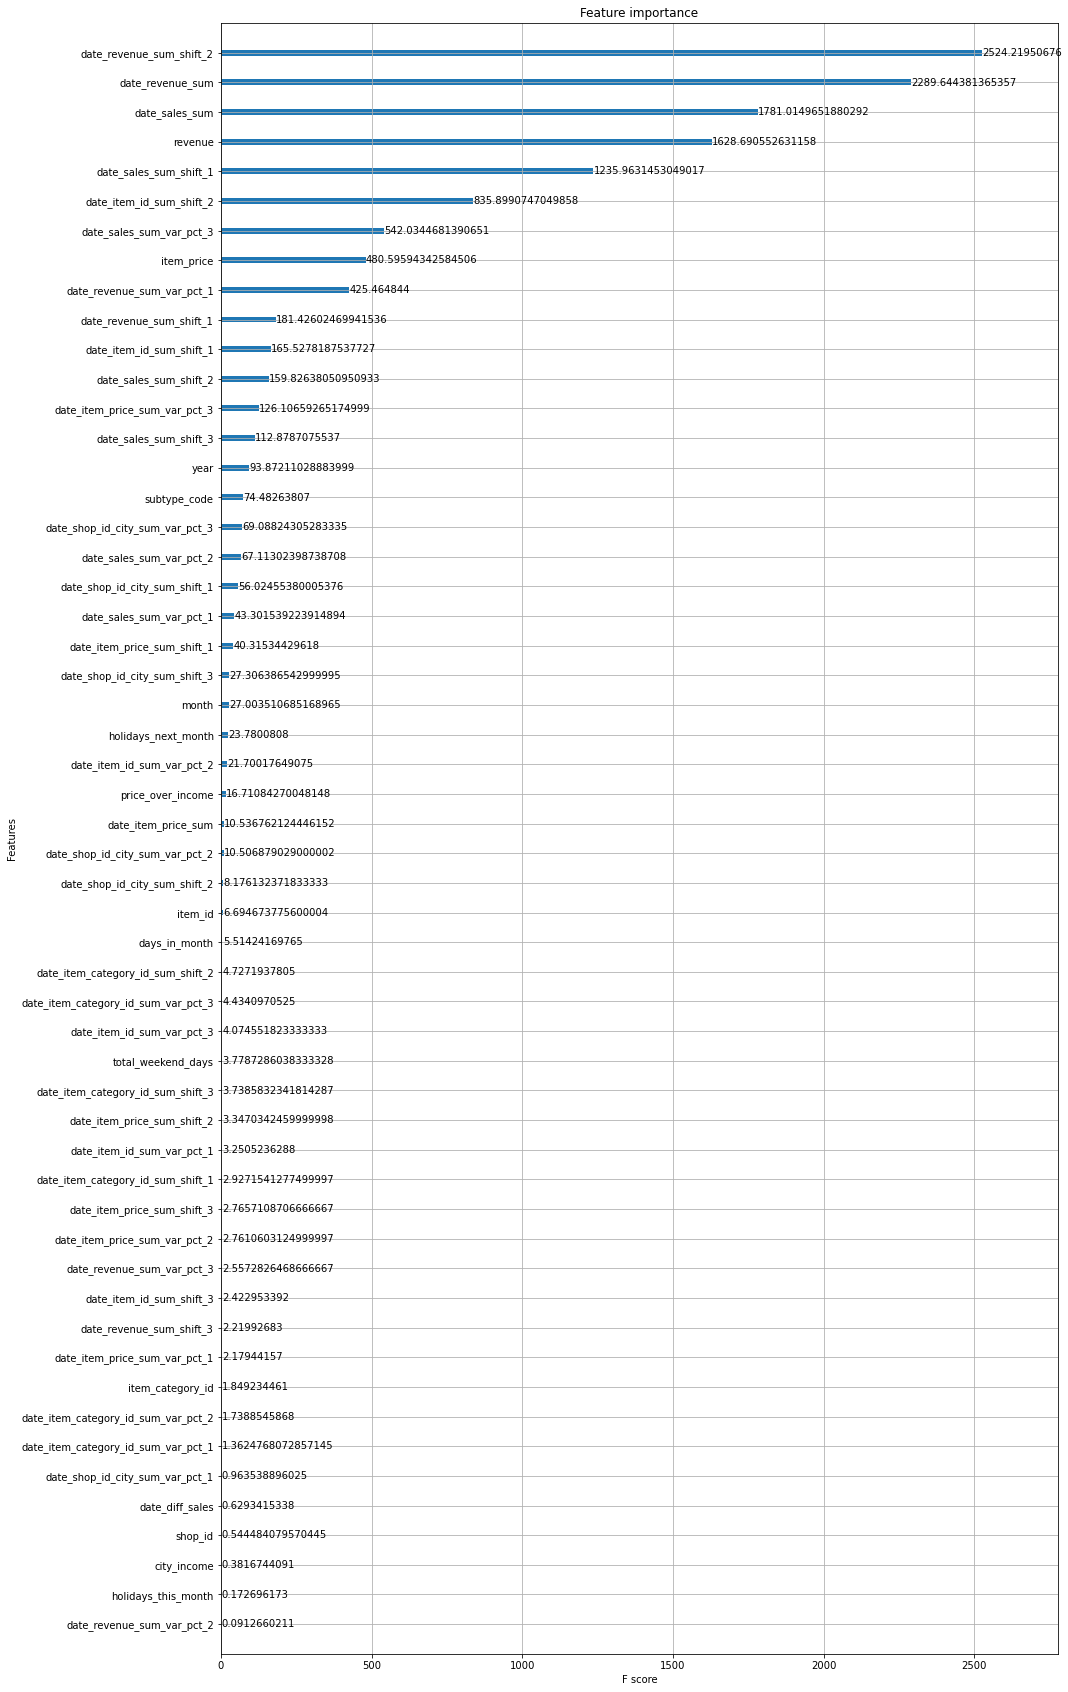

In [240]:
importance = model.get_booster().get_score(importance_type = "gain")
importance = {k: v for k, v in sorted(importance.items(), key = lambda item: item[1])}

# plot:
fig, ax = plt.subplots(figsize=(15, 30))
plot_importance(model, importance_type = "gain", ax = ax)
plt.savefig("{}_{}_plot_importance.png".format(model_name, t))

<a id = "predict_and_model_evaluation_2"></a>
# Predict and model evaluation of new model
[Go back to the table of contents](#table_of_contents)

In [241]:
Y_valida_pred = model.predict(X_valida)

metrics.r2_score(Y_valida, Y_valida_pred)

rmse_valida = sqrt(metrics.mean_squared_error(Y_valida, Y_valida_pred))
rmse_valida

0.08484164246262041

In [242]:
Y_test_predict = model.predict(X_test)

rmse_test = sqrt(metrics.mean_squared_error(Y_test, Y_test_predict))
rmse_test

0.0839020742068018